# Food For Thought 
## Digging into the dataset

The first step of this project aims at understanding the dataset we have chosen ([Open Food Facts Database](https://world.openfoodfacts.org/)), to check whether it is suitable for the kind of analysis we want to develop.

As a reminder, we would like to focus our research on two main topics:
1. Impact of food on environment
2. Impact of food on the health

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
from mpl_toolkits.mplot3d import Axes3D
from difflib import get_close_matches

import pickle

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import findspark
findspark.init()

from pyspark.sql import *

import pyspark.sql.functions as F

from pyspark.sql import SparkSession
from pyspark import SparkContext

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
%matplotlib inline


In [2]:
# functions to save and load intermediate results in pickle format
def load_pickle(file_path):
    with open(file_path, 'rb') as file:
        return pickle.load(file)

def save_pickle(result, file_path = 'pickle'):
    with open(file_path, 'wb') as file:
        pickle.dump(result, file)

In [3]:
style.use('seaborn-notebook') #sets the size of the charts
style.use('ggplot')

In [ ]:
DATA_FOLDER = './data/'
data = spark.read.csv(DATA_FOLDER +'en.openfoodfacts.org.products.csv',header=True,sep='\t')          

### Brand vs Nutrition vs Food Category in France 

#### load and clean

In [ ]:
bra_cat_nut = data.filter("countries_en=='France'")\
                    .select('brands', 'nutrition_grade_fr', 'pnns_groups_1')\
                    .dropna(how='all')

In [ ]:
bra_cat_nut = bra_cat_nut.withColumn('pnns_groups_1',(F.regexp_replace('pnns_groups_1', '-', ' ')))
square_udf_int = F.udf(lambda z: z.title() if z else z)
bra_cat_nut = bra_cat_nut.withColumn('pnns_groups_1',square_udf_int('pnns_groups_1'))

In [ ]:
bra_cat_nut.show(5)

In [ ]:
# we can now read it everytime we want to continue the analysis
bra_cat_nut_raw_df = pd.read_pickle('bra_cat_nut_raw_df')

In [ ]:
bra_cat_nut_raw_df.head()

The problem is that the 'brands' tags are not always consistent. For example we can find the brand tag 'carrefour', "Carrefour", "carrfour,bio carrefour' ect. 
Hence we first clean the brands using a list of food brands present in France and a function to match the 'brands' tag with the closest brand in the list. 

In [ ]:
# list of food brands present in France ('Coca Cola', 'Fleury Michon', 'Carrefour' ect.)
list_brand_file = open("brand_list.txt", "r")
list_brand = list_brand_file.read().split('\n')

# Function which find for each value (string) in the column 'brands' the closest brand (string) in 'list_brand'.
# Note: the function 'get_close_matches' has been imported from the open-source 'difflib' library.
def clean_brand(brand_name):
    
    # brand name can be of the form 'Carrefour' (one word) or 'Carrefour, Bio Carrefour' (multiple words)
    # hence we split the string w.r.t the symbol ',' and find the best matching brand word for each split.
    best=[]
    if brand_name:
        
        for word in brand_name.split(','):

            # the cutoff control for the False Positives possibilities in the 'list_brand' 
            # that don’t score at least the cutoff are ignored.
            # n controls for the the number of possibilities (whose score is higher than the cutoff value).
            best.append(get_close_matches(word.lower(), list_brand, n=1, cutoff=0.6))

        # remove empty sublists and unravel
        best = [brand for sublist in best for brand in sublist if sublist]
 
    if best:
        return best[0]
    else:
        return None


In [ ]:
# we create a new column with the new "consistent" brand tag. 
# takes some minutes to run...
bra_cat_nut_raw_df['new_brands'] = bra_cat_nut_raw_df['brands'].apply(lambda x: clean_brand(x))

In [ ]:
# we set to None the brand when it is "Sans Marque" 
# "Sans Marque" means the brands had not been specified, it can be "Marque Repère", "Délisse" ect. 
# using the product search tool on https://fr.openfoodfacts.org with the tag "Sans Marque".
bra_cat_nut_raw_df['new_brands'] = bra_cat_nut_raw_df['new_brands'].apply(lambda x: None if x == 'Sans Marque' else x)

In [ ]:
# drop when both 'nutrition_grade_fr' and 'brands' are None
bra_cat_nut_cleaned_df = bra_cat_nut_raw_df.dropna(subset=['nutrition_grade_fr', 'brands'], how='all') 

# we can drop the old column 'brands' since we have the new ones.
bra_cat_nut_cleaned_df = bra_cat_nut_cleaned_df.drop('brands',1).rename(columns={'new_brands':'brands'})

bra_cat_nut_cleaned_df.head()

In [ ]:
# here we count the number of products for each brand. 
# we consider that brand have enough products to be analyzed from 100 products
count = bra_cat_nut_cleaned_df.groupby('brands').count().sort_values('nutrition_grade_fr', ascending=False)
count.head()

In [ ]:
count['enough_products']= count[['nutrition_grade_fr']].apply(lambda x: x>100)
count = count[count.enough_products]
count.head()

The most abundant brands are Carrefour, Auchan and U. There are the brands of the biggest distributors (supermarkets) in France. 

In [ ]:
# here we add the column "enough products" to the dataframe with the cleaned brand.
bra_cat_nut_cleaned_df = bra_cat_nut_cleaned_df.join(count[['enough_products']], on='brands')
bra_cat_nut_cleaned_df = bra_cat_nut_cleaned_df.drop('enough_products',1)
bra_cat_nut_cleaned_df.head()

In [ ]:
# here we create dummy variables from the 'nutrition_grade_fr' whose value can be:
# - 'a' (very good product for health) 
# - 'b' (good product)
# - 'c' ('neutral product')
# - 'd' ('not so good product')
# - 'e' (bad product for health)

bra_cat_nut_cleaned_dummies_df = pd.get_dummies(bra_cat_nut_cleaned_df.set_index('brands')).reset_index()
bra_cat_nut_cleaned_dummies_df = bra_cat_nut_cleaned_expanded_df.rename(columns=
                              {'nutrition_grade_fr_a':'a',
                               'nutrition_grade_fr_b':'b',
                               'nutrition_grade_fr_c':'c',
                               'nutrition_grade_fr_d':'d',
                               'nutrition_grade_fr_e':'e',
                              'pnns_groups_1_Beverages': 'Beverages',
                              'pnns_groups_1_Cereals And Potatoes':'Cereals And Potatoes',
                              'pnns_groups_1_Composite Foods': 'Composite Foods',
                              'pnns_groups_1_Fat And Sauces':'Fat And Sauces',
                              'pnns_groups_1_Fish Meat Eggs':'Fish Meat Eggs',
                              'pnns_groups_1_Fruits And Vegetables':'Fruits And Vegetables',
                              'pnns_groups_1_Milk And Dairy Products':'Milk And Dairy Products',
                              'pnns_groups_1_Salty Snacks':'Salty Snacks',
                              'pnns_groups_1_Sugary Snacks':'Sugary Snacks',
                              'pnns_groups_1_Unknown': 'Unknown'})
bra_cat_nut_cleaned_dummies_df.head(5)

#### Load data

In [4]:
bra_cat_nut_df = pd.read_pickle('bra_cat_nut_cleaned_df')
bra_cat_nut_dummies_df = pd.read_pickle('bra_cat_nut_cleaned_dummies_df')

#### Food quality in the whole dataset

In [5]:
bra_cat_nut_df.head(3)

,nutrition_grade_fr,pnns_groups_1,brands
0,None,Unknown,Crous
1,d,Unknown,Crous
2,None,Unknown,None


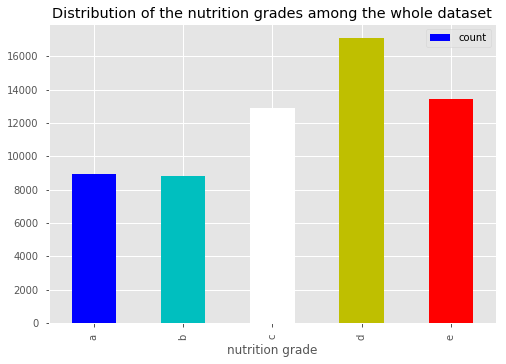

In [6]:
count = bra_cat_nut_df[['nutrition_grade_fr','brands']].groupby('nutrition_grade_fr').count().rename(columns={'brands':'count'})
count.plot(kind='bar', color='bcwyr')
plt.title('Distribution of the nutrition grades among the whole dataset')
plt.xlabel('nutrition grade') 
plt.show()

### Food quality for each brand

In [7]:
bra_nut_df = bra_cat_nut_df[['brands', 'nutrition_grade_fr']]
bra_nut_dummies_df = bra_cat_nut_dummies_df.iloc[:,np.arange(6)]

In [8]:
# extract the total number of products for each brands
brand_count = bra_nut_df.groupby('brands').count().rename(columns={'nutrition_grade_fr':'total'})
brand_count.head()

,total
brands,
,0
123 bio,421
7Up,34
A l'olivier,67
Ajax,2


In [9]:
# here we count the nutrition grade occurences for each brand
brand_dummies_count = bra_nut_dummies_df.groupby('brands').sum()
brand_dummies_count.head(3)

,a,b,c,d,e
brands,,,,,
,0.0,0.0,0.0,0.0,0.0
123 bio,121.0,75.0,54.0,91.0,80.0
7Up,0.0,5.0,1.0,4.0,24.0


In [10]:
# we add the column total (with the total number of products sold for each brand) to further extract the ratio of each grade instead of the raw count.
brand_dummies_count = brand_dummies_count.join(brand_count)#.rename(columns = {'nutrition_grade_fr':'total'})
brand_dummies_count.head()

,a,b,c,d,e,total
brands,,,,,,
,0.0,0.0,0.0,0.0,0.0,0.0
123 bio,121.0,75.0,54.0,91.0,80.0,421.0
7Up,0.0,5.0,1.0,4.0,24.0,34.0
A l'olivier,0.0,2.0,19.0,43.0,3.0,67.0
Ajax,1.0,0.0,0.0,0.0,1.0,2.0


In [11]:
# we convert the counts into ratios. (ex: ratio for 'a' = count for 'a' / total number of products)
ratio = brand_dummies_count.copy()
ratio[['a','b','c','d','e']] = brand_dummies_count[['a','b','c','d','e']].div(brand_dummies_count['total'].values,axis=0)
ratio = ratio.sort_values('total',ascending=False)

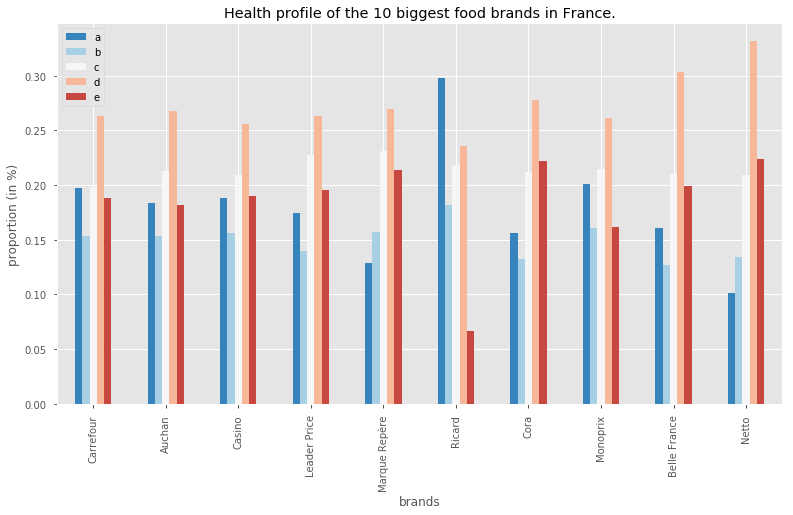

In [12]:
ratio.reset_index().loc[:9].drop('total',1).plot(kind='bar', x='brands',figsize=[13,7], color=sns.color_palette("RdBu_r", 5))
plt.ylabel('proportion (in %)')
plt.title('Health profile of the 10 biggest food brands in France.')
plt.show()

In [13]:
top10_brand_names = ratio.index[:9]

We observe for example that for almost all the biggest food brands present in France the prominent nutrition category is "junk" food. We don't eat that well in France... 

The two biggest exceptions are 'Danone' and 'Picard'. They mainly sell products from milk and frozen food which could be excpected to be healthier than the products sold by Fleury Michon (mainly transformed products from meat).  

Interestingly the 'Bio Village' brand solds a lot of 'junk' food... Even more than 'neutral' food.

### Category Distribution in the 10 biggest food brands in France. 

In [14]:
bra_cat_df = bra_cat_nut_df[['brands', 'pnns_groups_1']]
bra_cat_dummies_df = bra_cat_nut_dummies_df.iloc[:,[0,6,7,8,9,10,11,12,13,14,15]]
bra_cat_dummies_df.head()

,brands,Beverages,Cereals And Potatoes,Composite Foods,Fat And Sauces,Fish Meat Eggs,Fruits And Vegetables,Milk And Dairy Products,Salty Snacks,Sugary Snacks,Unknown
0,Crous,0,0,0,0,0,0,0,0,0,1
1,Crous,0,0,0,0,0,0,0,0,0,1
2,Crous,0,0,0,0,0,1,0,0,0,0
3,Crous,0,0,0,0,0,0,0,0,0,1
4,Crous,0,0,0,0,0,0,0,0,0,1


In [15]:
# here we count the category occurences for each brand
brand_dummies_count = bra_cat_dummies_df.groupby('brands').sum()
brand_dummies_count.head(3)

,Beverages,Cereals And Potatoes,Composite Foods,Fat And Sauces,Fish Meat Eggs,Fruits And Vegetables,Milk And Dairy Products,Salty Snacks,Sugary Snacks,Unknown
brands,,,,,,,,,,
,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123 bio,38.0,60.0,28.0,38.0,28.0,64.0,43.0,15.0,72.0,222.0
7Up,29.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0


In [16]:
# we add the column total (with the total number of products sold for each brand) to further extract the ratio of each grade instead of the raw count.
brand_dummies_count = brand_dummies_count.join(brand_count)#.rename(columns = {'nutrition_grade_fr':'total'})
brand_dummies_count.head()

,Beverages,Cereals And Potatoes,Composite Foods,Fat And Sauces,Fish Meat Eggs,Fruits And Vegetables,Milk And Dairy Products,Salty Snacks,Sugary Snacks,Unknown,total
brands,,,,,,,,,,,
,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123 bio,38.0,60.0,28.0,38.0,28.0,64.0,43.0,15.0,72.0,222.0,421.0
7Up,29.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,34.0
A l'olivier,0.0,1.0,2.0,41.0,1.0,0.0,0.0,0.0,2.0,67.0,67.0
Ajax,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0,2.0


In [17]:
# we convert the counts into ratios. (ex: ratio for 'a' = count for 'a' / total number of products)
ratio = brand_dummies_count.copy().reset_index()
ratio = ratio[ratio['brands'].isin(top10_brand_names)].set_index('brands')
ratio.iloc[:,[0,1,2,3,4,5,6,7,8,9]] = brand_dummies_count.iloc[:,[0,1,2,3,4,5,6,7,8,9]].div(brand_dummies_count['total'].values,axis=0)
ratio.head()

,Beverages,Cereals And Potatoes,Composite Foods,Fat And Sauces,Fish Meat Eggs,Fruits And Vegetables,Milk And Dairy Products,Salty Snacks,Sugary Snacks,Unknown,total
brands,,,,,,,,,,,
Auchan,0.083194,0.100723,0.137173,0.076238,0.129382,0.105732,0.140234,0.034780,0.125487,0.647190,3594.0
Belle France,0.072476,0.082248,0.133550,0.067590,0.113192,0.105863,0.157166,0.051303,0.172638,0.181596,1228.0
Carrefour,0.077958,0.129015,0.136152,0.069174,0.139995,0.117486,0.123799,0.040626,0.163601,0.599231,3643.0
Casino,0.097216,0.109995,0.143770,0.059790,0.101324,0.095847,0.119580,0.044272,0.160201,0.628024,2191.0
Cora,0.108409,0.074357,0.124392,0.068798,0.138290,0.107019,0.100069,0.054899,0.164698,0.655316,1439.0


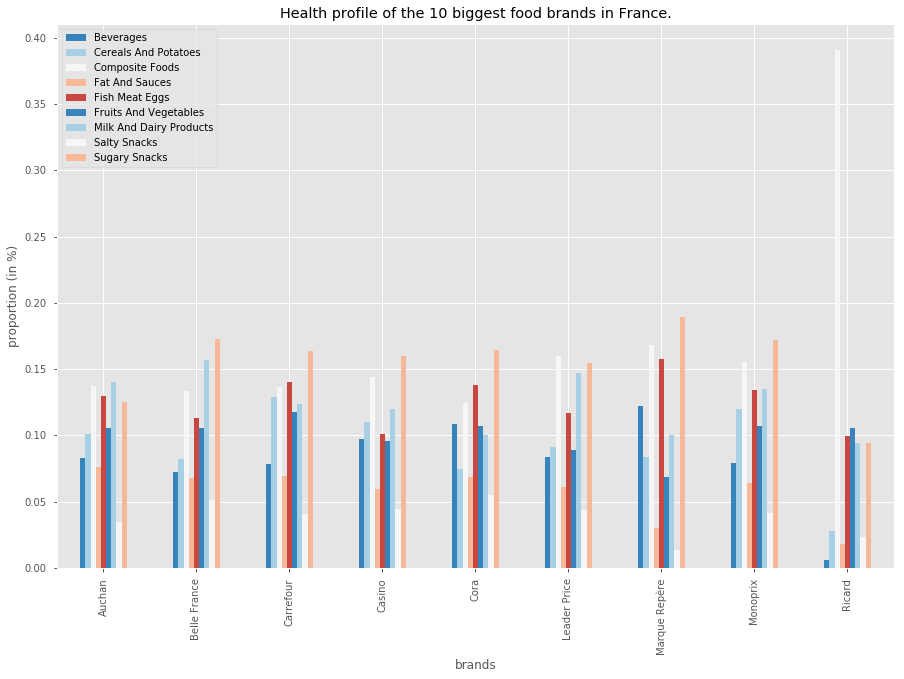

In [18]:
ratio.reset_index().drop(['total','Unknown'],1).plot(kind='bar', x='brands',figsize=[15,10], color=sns.color_palette("RdBu_r", 5))
plt.ylabel('proportion (in %)')
plt.title('Health profile of the 10 biggest food brands in France.')
plt.show()

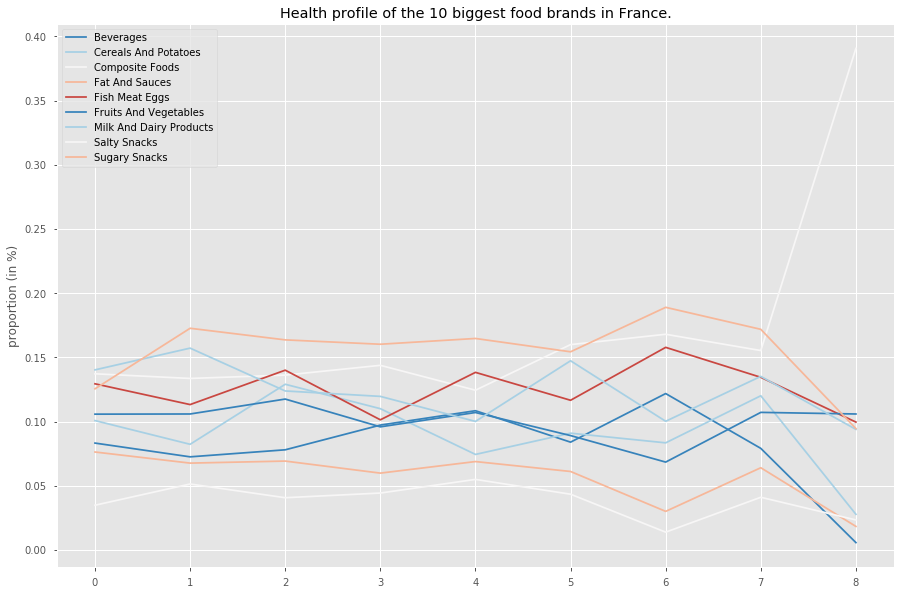

In [19]:
ratio.reset_index().drop(['total','Unknown'],1).plot(kind='line',figsize=[15,10], color=sns.color_palette("RdBu_r", 5))
plt.ylabel('proportion (in %)')
plt.title('Health profile of the 10 biggest food brands in France.')
plt.show()

## Nutrition grade repartition per category

In [20]:
cat_nut_df = bra_cat_nut_df[['pnns_groups_1', 'nutrition_grade_fr']].dropna()

In [21]:
cat_nut_df = pd.get_dummies(cat_nut_df.set_index('pnns_groups_1')).rename(columns=
                              {'nutrition_grade_fr_a':'a',
                               'nutrition_grade_fr_b':'b',
                               'nutrition_grade_fr_c':'c',
                               'nutrition_grade_fr_d':'d',
                               'nutrition_grade_fr_e':'e'})

In [22]:
count = cat_nut_df.groupby('pnns_groups_1').sum()
count['total'] = count.apply(lambda x: x['a']+x['b']+x['c']+x['d']+x['e'], axis=1) 
count.head()

,a,b,c,d,e,total
pnns_groups_1,,,,,,
Beverages,71.0,854.0,1812.0,1624.0,3754.0,8115.0
Cereals And Potatoes,3839.0,1630.0,1616.0,1045.0,101.0,8231.0
Composite Foods,1798.0,3407.0,3404.0,2073.0,185.0,10867.0
Fat And Sauces,164.0,316.0,1560.0,3408.0,1591.0,7039.0
Fish Meat Eggs,966.0,1144.0,2158.0,3270.0,2134.0,9672.0


In [23]:
ratio = count.copy()
ratio[['a','b','c','d','e']] = count[['a','b','c','d','e']].div(count['total'].values,axis=0)*100
ratio.head()

,a,b,c,d,e,total
pnns_groups_1,,,,,,
Beverages,0.874923,10.523722,22.329020,20.012323,46.260012,8115.0
Cereals And Potatoes,46.640748,19.803183,19.633094,12.695906,1.227068,8231.0
Composite Foods,16.545505,31.351799,31.324193,19.076102,1.702402,10867.0
Fat And Sauces,2.329876,4.489274,22.162239,48.415968,22.602642,7039.0
Fish Meat Eggs,9.987593,11.827957,22.311828,33.808933,22.063689,9672.0


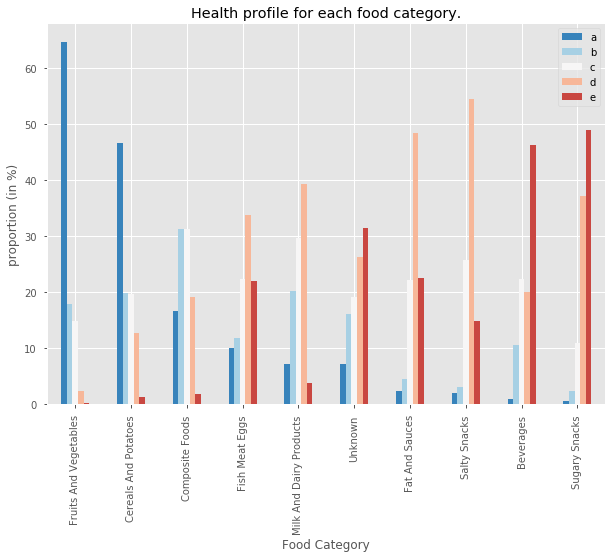

In [24]:
ratio.reset_index().drop('total',1).sort_values(by=['a'],ascending=0)\
.plot(kind='bar', x='pnns_groups_1',figsize=[10,7], color=sns.color_palette("RdBu_r", 5))
plt.xlabel('Food Category')
plt.ylabel('proportion (in %)')
plt.title('Health profile for each food category.')
plt.show()